
🔵 Training Normal Model (5 epochs)
Epoch 1/5 | Loss: 0.4007 | Acc: 98.51% | Frobenius Norm: 51.82
Epoch 2/5 | Loss: 0.0640 | Acc: 98.80% | Frobenius Norm: 60.30
Epoch 3/5 | Loss: 0.0508 | Acc: 98.69% | Frobenius Norm: 68.24
Epoch 4/5 | Loss: 0.0399 | Acc: 99.02% | Frobenius Norm: 75.11
Epoch 5/5 | Loss: 0.0355 | Acc: 98.77% | Frobenius Norm: 82.10

🔴 Training Overfit Model (50 epochs)
Epoch 1/50 | Loss: 0.5446 | Acc: 97.83% | Frobenius Norm: 49.27
Epoch 2/50 | Loss: 0.0773 | Acc: 98.46% | Frobenius Norm: 58.71
Epoch 3/50 | Loss: 0.0501 | Acc: 98.48% | Frobenius Norm: 64.32
Epoch 4/50 | Loss: 0.0459 | Acc: 98.55% | Frobenius Norm: 70.62
Epoch 5/50 | Loss: 0.0373 | Acc: 98.82% | Frobenius Norm: 75.52
Epoch 6/50 | Loss: 0.0344 | Acc: 99.15% | Frobenius Norm: 79.70
Epoch 7/50 | Loss: 0.0314 | Acc: 99.17% | Frobenius Norm: 83.88
Epoch 8/50 | Loss: 0.0232 | Acc: 99.10% | Frobenius Norm: 86.95
Epoch 9/50 | Loss: 0.0247 | Acc: 99.25% | Frobenius Norm: 90.62
Epoch 10/50 | Loss: 0.0250 | Acc: 9

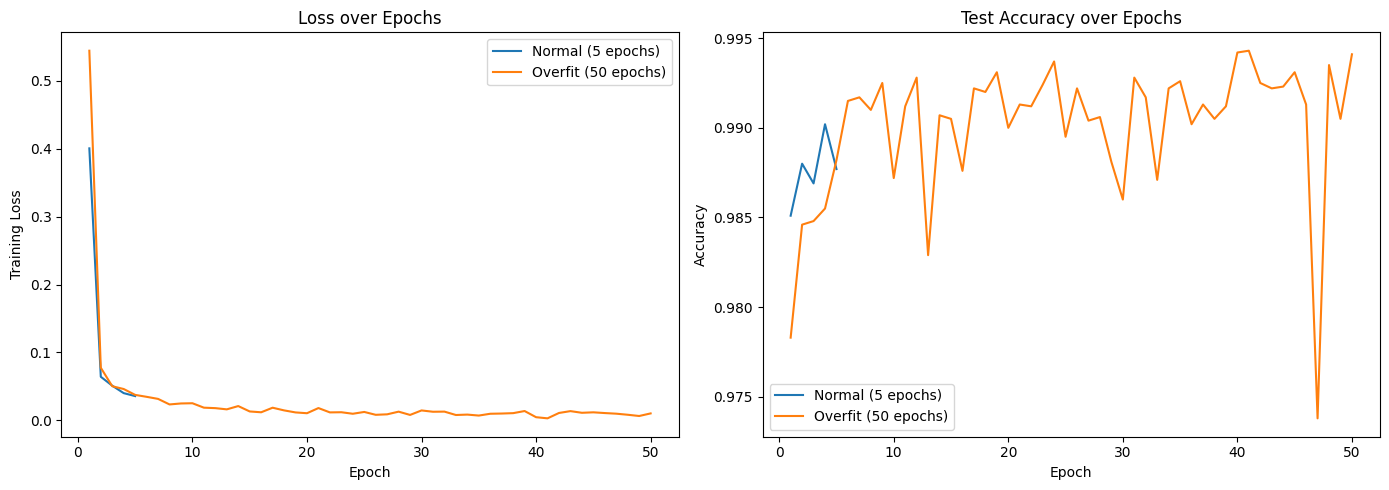

Final Frobenius Norms:
🔵 Normal: 82.10
🔴 Overfit: 168.99


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

class VGG11(nn.Module):
    def __init__(self, num_classes=10):
        super(VGG11, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(128, 256, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(256, 512, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(512, 512, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding=1), nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((1, 1))
        )
        self.classifier = nn.Sequential(
            nn.Linear(512, 512), nn.ReLU(True),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        return self.classifier(x)

def compute_frobenius_norm(model):
    weights = [param for name, param in model.named_parameters() if 'weight' in name]
    all_weights = torch.cat([w.flatten() for w in weights])
    return torch.norm(all_weights, p=2).item()

def train_model(model, optimizer, train_loader, test_loader, epochs=5, device='cpu'):
    criterion = nn.CrossEntropyLoss()
    model.to(device)
    train_loss, test_acc, frob_norms = [], [], []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        train_loss.append(total_loss / len(train_loader))

        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for inputs, targets in test_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == targets).sum().item()
                total += targets.size(0)
        acc = correct / total
        test_acc.append(acc)
        frob_norms.append(compute_frobenius_norm(model))
        print(f"Epoch {epoch+1}/{epochs} | Loss: {train_loss[-1]:.4f} | Acc: {acc*100:.2f}% | Frobenius Norm: {frob_norms[-1]:.2f}")
    return train_loss, test_acc, frob_norms

transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=256)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Train normal model
print("\n🔵 Training Normal Model (5 epochs)")
model_normal = VGG11()
optimizer_normal = optim.Adam(model_normal.parameters(), lr=0.001)
normal_loss, normal_acc, normal_frob = train_model(model_normal, optimizer_normal, train_loader, test_loader, epochs=5, device=device)

# Train overfit model
print("\n🔴 Training Overfit Model (50 epochs)")
model_overfit = VGG11()
optimizer_overfit = optim.Adam(model_overfit.parameters(), lr=0.001)
overfit_loss, overfit_acc, overfit_frob = train_model(model_overfit, optimizer_overfit, train_loader, test_loader, epochs=50, device=device)

# Plotting
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, 6), normal_loss, label="Normal (5 epochs)")
plt.plot(range(1, 51), overfit_loss, label="Overfit (50 epochs)")
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, 6), normal_acc, label="Normal (5 epochs)")
plt.plot(range(1, 51), overfit_acc, label="Overfit (50 epochs)")
plt.title("Test Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

print(f"Final Frobenius Norms:\n🔵 Normal: {normal_frob[-1]:.2f}\n🔴 Overfit: {overfit_frob[-1]:.2f}")
